## Homogenous (stationary) Markov Chain Implementation in Edward

### Package Imports and Options

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
import edward as ed
from edward.models import Bernoulli, Categorical, Normal

from utils.utils import load_dataframe, load_data_dic, preprocess

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)

sns.set_style('whitegrid')

### Load Data

In [3]:
dic = load_data_dic()

Loading data dictionary...
Retrieved 153 fields


In [7]:
df_raw = load_dataframe()

Loading raw data from csvs...


/Users/jeromekafrouni/.pyenv/versions/3.6.1/envs/prob-prog/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['id', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'revol_util', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type', 'verification_status_joint', 'sec_app_earliest_cr_line', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status', 'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date']]

  return pytables.

Fetching and caching raw data took 125.37 seconds
Retrieved 2,004,091 rows, 151 columns


In [8]:
# use these features to start
features = ['loan_status', 'annual_inc', 'avg_cur_bal', 'int_rate',
            'emp_length', 'funded_amnt', 'grade', 'home_ownership', 
            'loan_amnt', 'term', 'installment', 'verification_status', 
            'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 
            'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'sub_grade',
           'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']

In [9]:
# whenever we need to reset to raw df we can run this
df = df_raw[features].copy()

In [10]:
dic[dic['LoanStatNew'].isin(features)]

,LoanStatNew,Description
4,annual_inc,The self-reported annual income provided by the borrower during registration.
7,avg_cur_bal,Average current balance of all accounts
13,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
16,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
19,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
23,funded_amnt,The total amount committed to that loan at that point in time.
25,grade,LC assigned loan grade
26,home_ownership,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER"
32,inq_last_6mths,The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
33,installment,The monthly payment owed by the borrower if the loan originates.


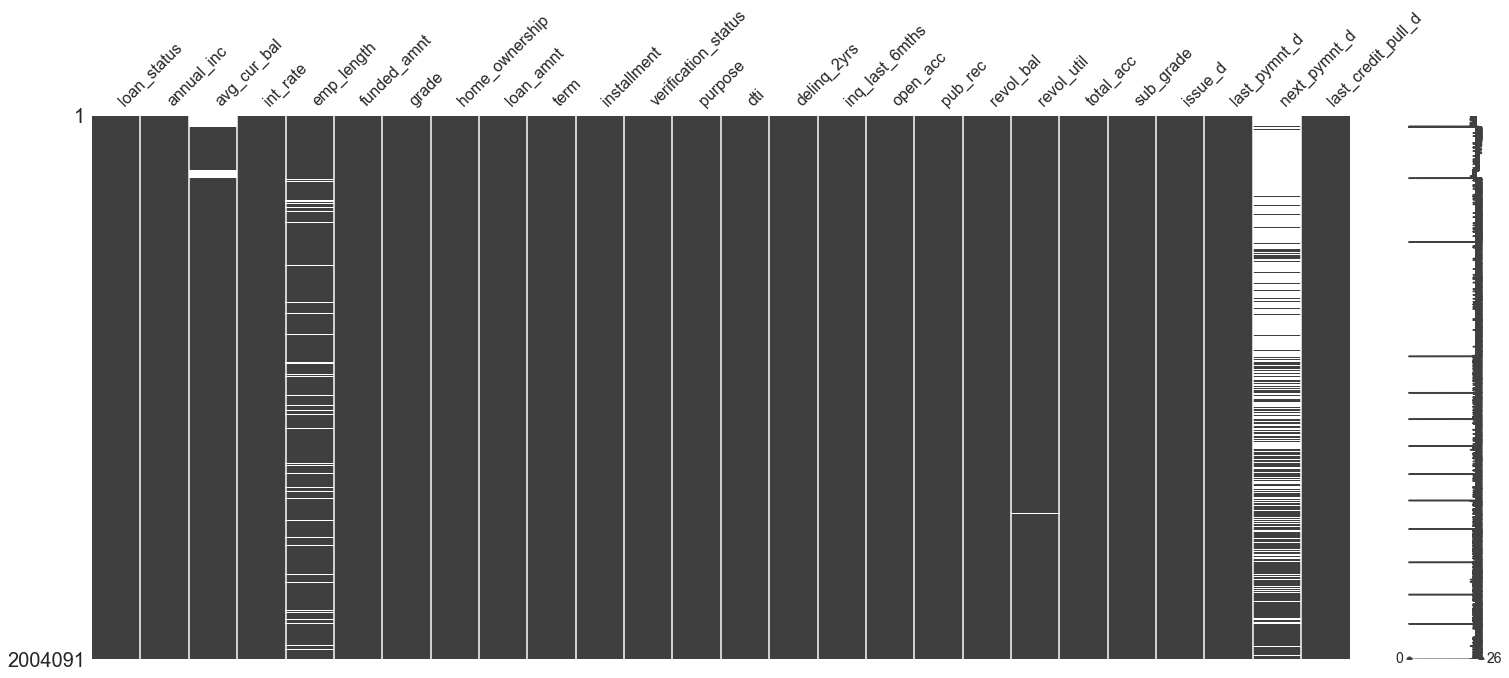

In [11]:
msno.matrix(df)

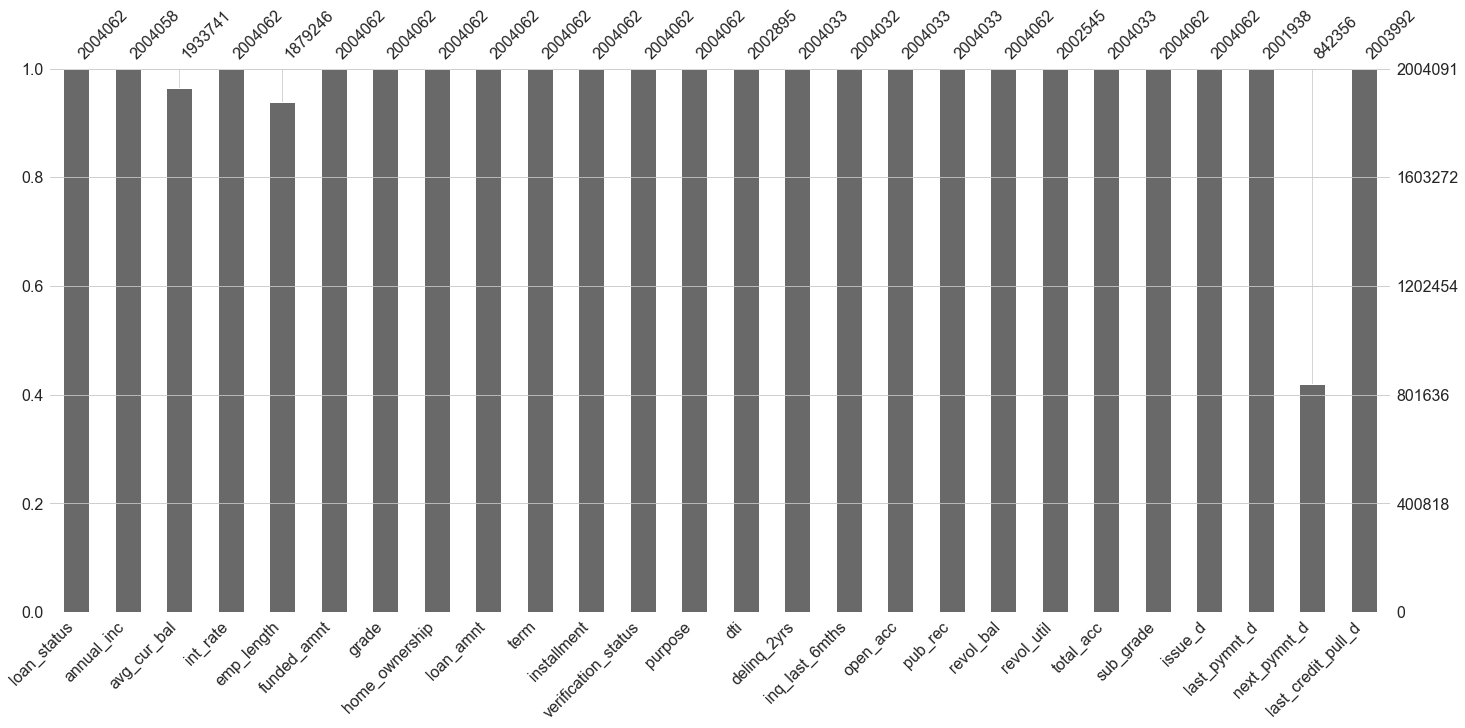

In [12]:
msno.bar(df)

### Preprocessing

In [13]:
df = preprocess(df)

Preprocessing data...


/Users/jeromekafrouni/.pyenv/versions/3.6.1/envs/prob-prog/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['loan_status', 'int_rate', 'emp_length', 'grade', 'home_ownership', 'verification_status', 'purpose', 'revol_util', 'sub_grade', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Preprocessing and caching took 110.45 seconds
Preprocessed 2,004,062 rows, 28 columns


In [15]:
df.loc[:, ['age_in_days', 'age_in_months']].sample(20)

,age_in_days,age_in_months
116189,1004 days,33
93202,1979 days,65
18811,944 days,31
38709,699 days,23
51585,883 days,29
370361,1338 days,44
88536,1522 days,50
89584,457 days,15
64682,638 days,21
49584,1461 days,48


In [16]:
df.dtypes

loan_status            object         
annual_inc             float64        
avg_cur_bal            float64        
int_rate               object         
emp_length             object         
funded_amnt            float64        
grade                  object         
home_ownership         object         
loan_amnt              float64        
term                   int64          
installment            float64        
verification_status    object         
purpose                object         
dti                    float64        
delinq_2yrs            float64        
inq_last_6mths         float64        
open_acc               float64        
pub_rec                float64        
revol_bal              float64        
revol_util             object         
total_acc              float64        
sub_grade              object         
issue_d                datetime64[ns] 
last_pymnt_d           object         
next_pymnt_d           object         
last_credit_pull_d     ob

In [17]:
# get currently active loans
df_active = df.loc[df.age_in_months < df.term]

In [18]:
# split loans by 36 and 60 month terms
df_36 = df.loc[df.term == 36]
df_60 = df.loc[df.term == 60]
df_36.shape[0] + df_60.shape[0] == df.shape[0]

True

In [20]:
# split active loans by 36 and 60 month terms
df_active_36 = df_36.loc[df_36.age_in_months < df_36.term]
df_active_60 = df_60.loc[df_60.age_in_months < df_60.term]
df_active_36.shape[0] + df_active_60.shape[0] == df_active.shape[0]

True

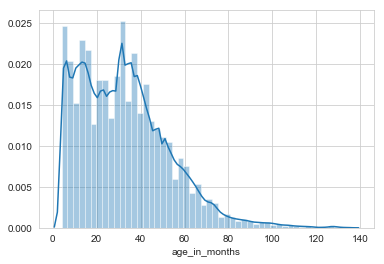

In [24]:
sns.distplot(df.age_in_months);

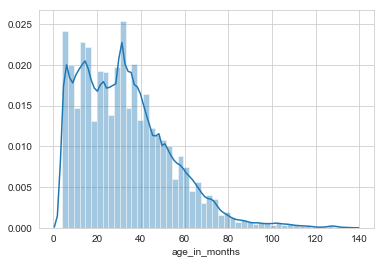

In [25]:
sns.distplot(df_36.age_in_months);

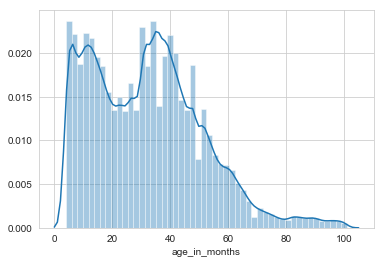

In [26]:
sns.distplot(df_60.age_in_months);

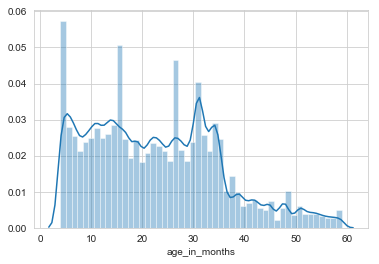

In [27]:
sns.distplot(df_active.age_in_months);

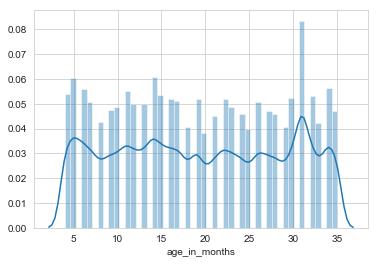

In [28]:
sns.distplot(df_active_36.age_in_months);

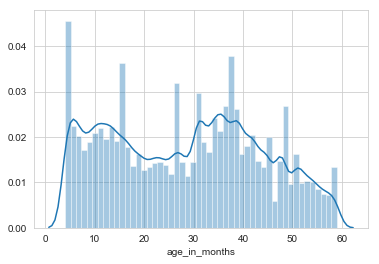

In [29]:
sns.distplot(df_active_60.age_in_months);

In [30]:
# TODO: we could try extracting months since last payment (q4_startdate - last_pymnt_d)
# resources
# http://www.utstat.toronto.edu/~rsalakhu/sta4273/notes/Lecture11.pdf
# https://github.com/blei-lab/edward/issues/450
# https://gist.github.com/fredcallaway/c7252b6326dfb502e70cad4146731aef
# https://discourse.edwardlib.org/t/a-simple-tensorflow-implementation-of-forward-backward/67
# https://gist.github.com/currymj/e903644c4e54e35fdb858c94f1631fe4

# https://discourse.edwardlib.org/t/any-tutorials-on-mcmc/179
# https://github.com/blei-lab/edward/blob/master/examples/bayesian_linear_regression.py 
# https://github.com/blei-lab/edward/blob/master/examples/rasch_model.py

In [31]:
# experimenting with: https://gist.github.com/fredcallaway/c7252b6326dfb502e70cad4146731aef
def categorical(ps):
    return Categorical(logits=ed.logit(ps)).value()

def flip(p):
    return tf.equal(Bernoulli(p=p), tf.constant(1))

def append(lst, x):
    return tf.concat(0, [lst, [x]])

class HMM(object):
    """A Hidden Markov Model."""

    def step(self, state):
        """Returns a new state following `state`."""
        raise NotImplementedError()

    def emit(self, state):
        """Returns an observable emission from `state`."""
        raise NotImplementedError()

    def init(self):
        """Returns an intial state."""
        raise NotImplementedError()

    def final(self, state):
        """Returns true if the model should stop in `state`."""
        raise NotImplementedError()
    
    def sample(self):
        def cond(states, emissions):
            s0 = states[-1]
            return self.final(s0) # TODO not final
        
        def body(states, emissions):
            s0 = states[-1]
            s1 = self.step(s0)
            e1 = self.emit(s1)
            return append(states, s1), append(emissions, e1)

        s0 = self.init()
        e0 = self.emit(s0)
        states = tf.convert_to_tensor([s0])
        emissions = tf.convert_to_tensor([e0])
        return tf.while_loop(
            cond, body, 
            loop_vars=[states, emissions],
            shape_invariants=[tf.TensorShape(None), tf.TensorShape(None)]
        )


class DiscreteGaussianHMM(HMM):
    """HMM with discrete transitions and gaussian emissions."""
    def __init__(self, P, mu, sigma, p_init, p_final):
        super().__init__()
        self.P = P
        self.mu = mu
        self.sigma = sigma
        self.p_init = p_init
        self.p_final = p_final

    def step(self, state):
        return categorical(self.P[state])

    def emit(self, state):
        return Normal(mu=self.mu[state], sigma=self.sigma[state]).value()

    def init(self):
        return categorical(self.p_init)

    def final(self, state):
        return flip(1 - tf.gather(self.p_final, state))
      

def demo():
    import matplotlib.pyplot as plt

    P = tf.constant(np.array([
        [.6, .4],
        [.2, .8],
    ], dtype='float32'))
    mu = tf.constant([5., -5.])
    sigma = tf.constant([1., 1.])
    model = DiscreteGaussianHMM(P, mu, sigma, [0.5, 0.5], [0.02, 0.02])

    sess = ed.get_session()
    emissions = [sess.run(model.sample()[1]) for _ in range(3)]
    for e in emissions:
        plt.plot(e)
    plt.show()

## States

In [37]:
states = list(df.loan_status.unique())
n_states = len(states)

In [38]:
transition_matrix_MLE = np.zeros((n_states, n_states))

In [39]:
states

['Fully Paid',
 'Charged Off',
 'Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off',
 'Current',
 'Late (31-120 days)',
 'Late (16-30 days)',
 'In Grace Period',
 'Default']

**Description from [the LC website](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-):**

- **Current**: Loan is up to date on all outstanding payments. 
 
- **In Grace Period**: Loan is past due but within the 15-day grace period. 
 
- **Late (16-30)**: Loan has not been current for 16 to 30 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.
 
- **Late (31-120)**: Loan has not been current for 31 to 120 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.
 
- **Fully paid**: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
 
- **Default**: Loan has not been current for an extended period of time.
 
- **Charged Off**: Loan for which there is no longer a reasonable expectation of further payments.
    - *Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance.*
    - *Charge Off typically occurs when a loan is 120 days or more past due and there is no reasonable expectation of sufficient payment to prevent the charge off.*
    - *Loans for which borrowers have filed for bankruptcy may be charged off earlier based on the date of bankruptcy notification.*
    - *More about the difference between Default and Charged Off [here](https://help.lendingclub.com/hc/en-us/articles/216127747)*

In [44]:
df_active_36.loc[df_active_36['loan_status'] == 'In Grace Period',:]

,loan_status,annual_inc,avg_cur_bal,int_rate,emp_length,funded_amnt,grade,home_ownership,loan_amnt,term,installment,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,sub_grade,issue_d,last_pymnt_d,next_pymnt_d,last_credit_pull_d,age_in_days,age_in_months
1423,In Grace Period,95000.0,14840.0,8.49%,10+ years,16000.0,B,MORTGAGE,16000.0,36,505.01,Not Verified,home_improvement,22.49,4.0,0.0,27.0,1.0,30824.0,60.2%,65.0,B1,2015-12-01,Oct-2018,Nov-2018,Oct-2018,1035 days,34
2074,In Grace Period,68000.0,23430.0,11.99%,1 year,8000.0,C,RENT,8000.0,36,265.68,Source Verified,credit_card,8.65,0.0,0.0,7.0,0.0,11229.0,71.1%,7.0,C1,2015-12-01,Oct-2018,Nov-2018,Oct-2018,1035 days,34
4139,In Grace Period,90000.0,15306.0,13.44%,NaN,9600.0,C,MORTGAGE,9600.0,36,325.51,Verified,credit_card,28.07,4.0,0.0,16.0,2.0,14168.0,67.5%,41.0,C3,2015-12-01,Sep-2018,Nov-2018,Oct-2018,1035 days,34
5730,In Grace Period,70000.0,8302.0,8.49%,< 1 year,10500.0,B,RENT,10500.0,36,331.42,Source Verified,credit_card,26.68,0.0,0.0,14.0,0.0,10059.0,54.1%,19.0,B1,2015-12-01,Sep-2018,Nov-2018,Oct-2018,1035 days,34
6418,In Grace Period,51000.0,1824.0,14.85%,10+ years,10000.0,C,MORTGAGE,10000.0,36,345.92,Verified,other,29.81,0.0,0.0,9.0,0.0,15100.0,64.3%,32.0,C5,2015-12-01,Oct-2018,Nov-2018,Oct-2018,1035 days,34
6449,In Grace Period,45000.0,2514.0,5.32%,< 1 year,19600.0,A,RENT,19600.0,36,590.25,Source Verified,debt_consolidation,18.63,1.0,1.0,11.0,0.0,17997.0,61.5%,36.0,A1,2015-12-01,Oct-2018,Nov-2018,Oct-2018,1035 days,34
6657,In Grace Period,24000.0,1569.0,12.88%,2 years,9100.0,C,RENT,9100.0,36,306.09,Source Verified,credit_card,7.60,0.0,1.0,28.0,0.0,1617.0,6.7%,29.0,C2,2015-12-01,Oct-2018,Nov-2018,Oct-2018,1035 days,34
6681,In Grace Period,183000.0,3686.0,8.49%,6 years,5000.0,B,RENT,5000.0,36,157.82,Not Verified,debt_consolidation,2.53,1.0,1.0,11.0,3.0,2342.0,21.7%,22.0,B1,2015-12-01,Sep-2018,Nov-2018,Oct-2018,1035 days,34
7306,In Grace Period,115000.0,6369.0,9.80%,2 years,7000.0,B,MORTGAGE,7000.0,36,225.22,Source Verified,small_business,12.94,0.0,0.0,15.0,0.0,47662.0,69.1%,22.0,B3,2015-12-01,Sep-2018,Nov-2018,Oct-2018,1035 days,34
7484,In Grace Period,67537.0,33447.0,11.22%,8 years,21000.0,B,MORTGAGE,21000.0,36,689.71,Not Verified,debt_consolidation,23.12,0.0,1.0,5.0,0.0,48821.0,99.6%,23.0,B5,2015-12-01,Oct-2018,Nov-2018,Oct-2018,1035 days,34


## Solving the Markov Model with MLE:

The MLE solution of a Markov Chain is simply the empirical frequencies of each transition. Even though we want to solve the problem from a Bayesian perspective, it's good to look at this estimate and have it in mind later.

**Problem:** how can we infer the states from the data, since we don't have month-by-month data?